In [1]:
from scipy import signal
import numpy as np
from scipy.io import wavfile
import plotly.express as px 
import matplotlib.pyplot as plt

In [2]:
#!pip install plotly

YIN PAPER 
http://audition.ens.fr/adc/pdf/2002_JASA_YIN.pdf

Explanation: https://www.youtube.com/watch?v=W585xR3bjLM

In [3]:
def f(x):  # Generates Signal
    f_0 = 1
    return np.sin(x*np.pi*2*f_0)

In [4]:
_CMNDF_cache_dict = {}
_DF_cache_dict = {} 
_ACF_cache_dict = {}

def clear_cache_dicts():
    global _CMNDF_cache_dict
    global _DF_cache_dict  
    global _ACF_cache_dict 
    print(len(_DF_cache_dict), len(_CMNDF_cache_dict), len(_ACF_cache_dict))
    _CMNDF_cache_dict.clear()
    _DF_cache_dict.clear() 
    _ACF_cache_dict.clear()
    print(len(_DF_cache_dict), len(_CMNDF_cache_dict), len(_ACF_cache_dict))
    print("hola")

In [5]:
def ACF(f, W, t, lag):
    # Calculates autocorr.
    # f: signal
    # W: window size
    # t: timestep
    # lag: number of samples to shift
    return np.cumsum(f[t: t+W] * f[lag+t:lag+t+W])[-1]

def ACF_cache(f, W, t, lag):
    if (t, lag) not in _ACF_cache_dict:
        _ACF_cache_dict[(t, lag)] = np.cumsum(f[t: t+W] * f[lag+t:lag+t+W])[-1]
    return _ACF_cache_dict[(t, lag)]
    

In [6]:
def detect_pitch(f, W, t, sample_rate, bounds):
    # Estimates signal pitch
    # f: signal
    # W: window size
    # t: timestep
    # sample_rate: signal sample rate
    # bounds: range of samples quantity to lag signal.
    ACF_vals = [ACF(f, W, t, i) for i in range(*bounds)]
    sample = np.argmax(ACF_vals)+bounds[0]
    return sample_rate/sample #convert to frequency


In [7]:
# Test
sample_rate = 500 #signal sample rate
start = 0 #signal t0
end = 5 #signal tf
num_samples = int(sample_rate * (end - start) + 1)
window_size = 200 # autcorr window size
bounds = [20, num_samples //2] #from 20 samples lag to half of the signal.
x = np.linspace(start, end, num_samples)
print(detect_pitch(f(x), window_size, 1, sample_rate, bounds))

0.49554013875123887


#### Test with decreasing amplitude signal.

In [8]:
def dicreasing_f(x):  # Generates Signal
    f_0 = 1
    envelope = lambda x: np.exp(-x)
    return np.sin(x*np.pi*2*f_0) * envelope(x)

In [9]:
# Test 2
sample_rate = 500 #signal sample rate
start = 0 #signal t0
end = 5 #signal tf
num_samples = int(sample_rate * (end - start) + 1)
window_size = 200 # autcorr window size
bounds = [20, num_samples //2] #from 20 samples lag to half of the signal.
x = np.linspace(start, end, num_samples)
print(detect_pitch(dicreasing_f(x), window_size, 1, sample_rate, bounds))

25.0


#### Take into account the square when calculating autocorr. If not, negative terms cancel out.

In [10]:
def DF(f, W, t, lag):
    return ACF(f, W, t, 0)+ACF(f, W, t+lag, 0) - (2*ACF(f, W, t, lag))

def DF_cache(f, W, t, lag):
    if (t, lag) not in _DF_cache_dict:
        _DF_cache_dict[(t, lag)] = ACF_cache(f, W, t, 0)+ACF_cache(f, W, t+lag, 0) - (2*ACF_cache(f, W, t, lag))
    return _DF_cache_dict[(t, lag)]

def detect_pitch_square(f, W, t, sample_rate, bounds):
    DF_vals = [DF(f, W, t, i) for i in range(*bounds)]
    sample = np.argmin(DF_vals)+bounds[0]
    return sample_rate/sample

In [11]:
# Test 2
print(detect_pitch_square(dicreasing_f(x), window_size, 1, sample_rate, bounds))

25.0


#### Cumulative mean normalize difference function

In [12]:
def CMNDF(f, W, t, lag):
    if lag == 0:
        return 1
    return DF(f, W, t, lag) / np.sum([DF(f, W, t, j+1) for j in range(lag)])*lag

def CMNDF_cache(f, W, t, lag):
    if lag == 0:
        return 1
    if (lag, t) not in _CMNDF_cache_dict:
        _CMNDF_cache_dict[(lag, t)] = DF_cache(f, W, t, lag) / np.sum([DF_cache(f, W, t, j+1) for j in range(lag)])*lag
    return _CMNDF_cache_dict[(lag, t)]

In [141]:
def detect_pitch_cmndf(f, W, t, sample_rate, bounds, thresh=0.3):
    CMNDF_vals = [CMNDF(f, W, t, i) for i in range(*bounds)]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh: # Get first sample below threshold (first octave)
            sample = i
            # Check for min near sample.
            subsample = sample
            for j in range(0, int(sample/0.8) - sample):
                if (CMNDF_vals[sample + j]  < CMNDF_vals[subsample]):
                    subsample = sample + j # New min.
            sample = subsample + bounds[0]
            break
    if sample is None:
        sample =  sample_rate #np.argmin(CMNDF_vals)+bounds[0] # Absolute min
    return sample_rate/sample

def detect_pitch_cmndf_cache(f, W, t, sample_rate, bounds, thresh=0.3, pev_w_energy=0):
    energy = np.sum(f[t:t+W]**2)/W
    no_speach = True
    if pev_w_energy != 0:
        no_speach = energy < pev_w_energy * 0.5
        energy = pev_w_energy if no_speach else energy
    
    CMNDF_vals = [CMNDF_cache(f, W, t, i) for i in range(*bounds)]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh: # Get first sample below threshold (first octave)
            sample = i
            # Check for min near sample.
            subsample = sample
            max_samp = min(int(sample/0.8) - sample, len(CMNDF_vals)-sample-1)
            if sample + max_samp > len(CMNDF_vals):
                print("error no entinedo pq")
               
            for j in range(0,  max_samp):
                if (CMNDF_vals[sample + j]  < CMNDF_vals[subsample]):
                    subsample = sample + j # New min.
            sample = subsample + bounds[0]
            no_speach = False
            break
    if sample is None:
        sample = sample_rate if no_speach else np.argmin(CMNDF_vals)+bounds[0] # Absolute min
    return sample_rate/sample, energy if (pev_w_energy != 0) and not no_speach else 0

def detect_pitch_cmndf_cache_log(f, W, t, sample_rate, bounds, thresh=0.3):
    steps = np.unique(np.logspace(*np.log10(bounds), 500, dtype=int))
    CMNDF_vals = [CMNDF_cache(f, W, t, i) for i in steps]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh: # Get first sample below threshold (first octave)
            sample = i
            # Check for min near sample.
            subsample = sample
            new_cmndf = [CMNDF_cache(f, W, t, i) for i in range(steps[i-2], steps[i+2])]
            sample = np.argmin(new_cmndf) + steps[i-2]
            break
    if sample is None:
        sample = sample_rate #np.argmin(CMNDF_vals)+bounds[0] # Absolute min
    return sample_rate/sample

In [14]:
%%time
print(detect_pitch_cmndf(dicreasing_f(x), window_size, 1, sample_rate, bounds))

1.002004008016032
Wall time: 13.1 s


In [15]:
%%time
clear_cache_dicts()
print(detect_pitch_cmndf_cache(dicreasing_f(x), window_size, 1, sample_rate, bounds)[0])

0 0 0
0 0 0
hola
1.002004008016032
Wall time: 370 ms


## with files

In [16]:
sample_rate, data = wavfile.read("assets/tenor.wav")
data = data.astype(np.float64)
min_freq = 20
max_freq = 500
window_size = int(sample_rate // min_freq * 1.2)

min_bound = sample_rate // max_freq
max_bound = sample_rate // min_freq
bounds = [min_bound, max_bound]

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16672/3361053704.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read("assets/tenor.wav")


1249 1230 2499
0 0 0
hola


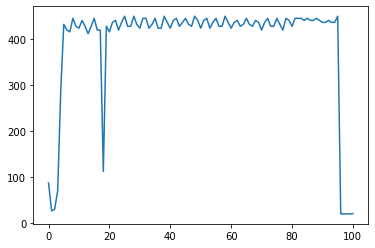

Wall time: 1min 53s


In [17]:
%%time
pitches = []
clear_cache_dicts()
e = 0
for i in range(data.shape[0] // (window_size+3)):
    p, e = detect_pitch_cmndf_cache(
            data[:,0],
            window_size,
            i*window_size,
            sample_rate,
            bounds,
            0.2,
            e
        ) 
    pitches.append(p)

plt.plot(pitches)
plt.show()

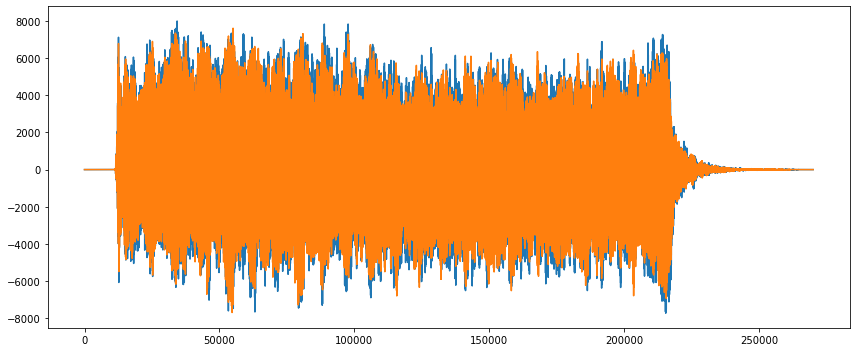

In [18]:
plt.figure(figsize=(12,5))
plt.plot(data)
plt.tight_layout()
plt.show()

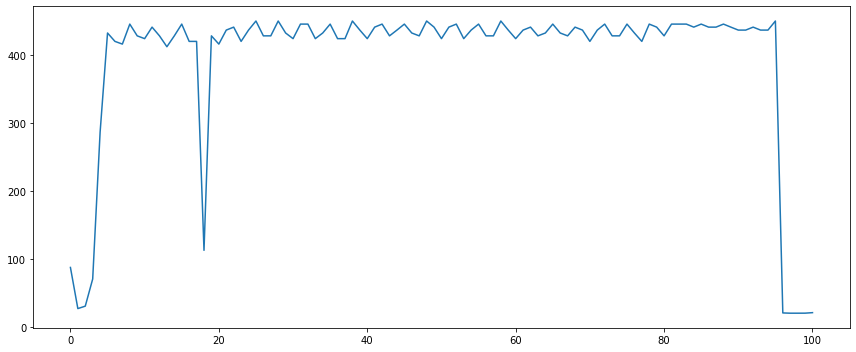

In [19]:
plt.figure(figsize=(12,5))
plt.plot(pitches)
plt.tight_layout()
plt.show()

## 246Hz Audio

In [29]:
sample_rate, data = wavfile.read("assets/246.9Hz.wav")
data = data.astype(np.float64)
min_freq = 20
max_freq = 500
window_size = int(sample_rate // min_freq * 1.2)

min_bound = sample_rate // max_freq
max_bound = sample_rate // min_freq
bounds = [min_bound, max_bound]

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16672/3455589826.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read("assets/246.9Hz.wav")


9862 9427 19729
0 0 0
hola


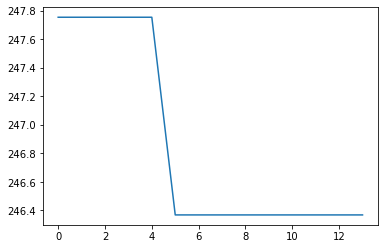

Wall time: 15.2 s


In [30]:
%%time
pitches = []
clear_cache_dicts()
e = 0
for i in range((data.shape[0]-bounds[1]) // (window_size+3)):
    p, e = detect_pitch_cmndf_cache(
            data[:,0],
            window_size,
            i*window_size,
            sample_rate,
            bounds,
            0.2,
            e
        ) 
    pitches.append(p)
plt.plot(pitches)
plt.show()

## 300Hz Audio

In [22]:
sample_rate, data = wavfile.read("assets/300Hz.wav")
data = data.astype(np.float64)
min_freq = 20
max_freq = 500
window_size = int(sample_rate // min_freq * 1.2)

min_bound = sample_rate // max_freq
max_bound = sample_rate // min_freq
bounds = [min_bound, max_bound]

30856 29638 61726
0 0 0
hola


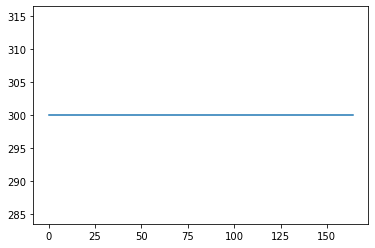

Wall time: 3min 12s


In [23]:
%%time
pitches = []
clear_cache_dicts()
e = 0
for i in range((data.shape[0]-bounds[1]) // (window_size+3)):
    p, e = detect_pitch_cmndf_cache(
            data[:,0],
            window_size,
            i*window_size,
            sample_rate,
            bounds,
            0.2,
            e
        ) 
    pitches.append(p)

plt.plot(pitches)
plt.show()

## Audio de voz

In [55]:
sample_rate, data = wavfile.read("assets/test_voice.wav")
data = data.astype(np.float64)
min_freq = 80
max_freq = 500
window_size = int(sample_rate * 0.025)# int(sample_rate // min_freq * 1.2)

min_bound = sample_rate // max_freq
max_bound = sample_rate // min_freq
bounds = [min_bound, max_bound]

64692 26463 129492
0 0 0
hola


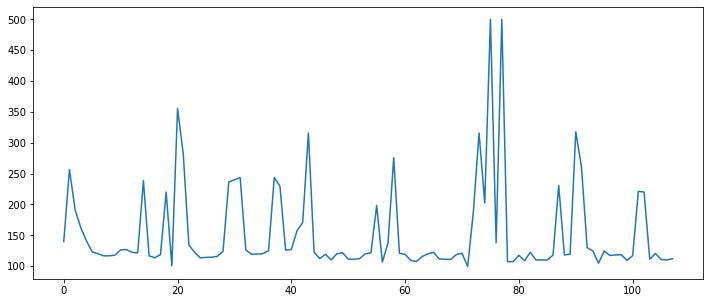

Wall time: 22 s


In [67]:
%%time
pitches = []
clear_cache_dicts()
e = 0
for i in range((data.shape[0]-bounds[1]) // (window_size+3)):
    p, e = detect_pitch_cmndf_cache(
            data[:,0],
            window_size,
            i*window_size,
            sample_rate,
            bounds,
            0.2,
            e
        ) 
    pitches.append(p)

# pitches = [detect_pitch_cmndf_cache_log(data, window_size, i*window_size, sample_rate, bounds) for i in range((data.shape[0]-bounds[1]) // (window_size+3))]   
plt.figure(figsize=(12,5))
plt.plot(pitches)
plt.show()

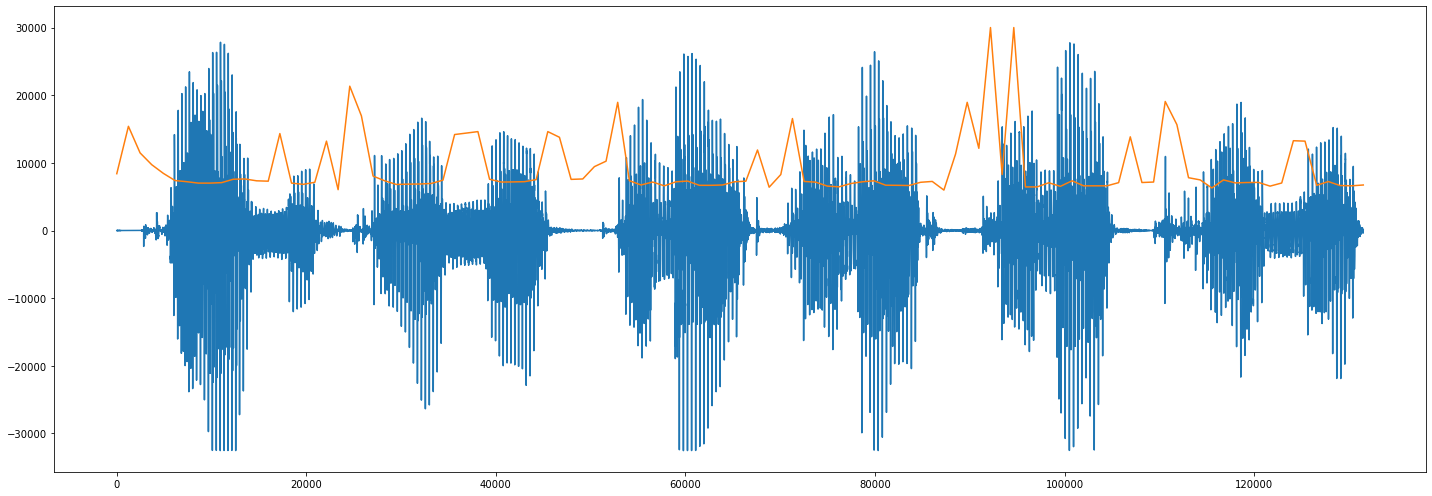

In [68]:
plt.figure(figsize=(20,7))
plt.plot(data)
plt.plot(np.linspace(0, len(data), len(pitches)), 60*np.array(pitches))
plt.tight_layout()
plt.show()

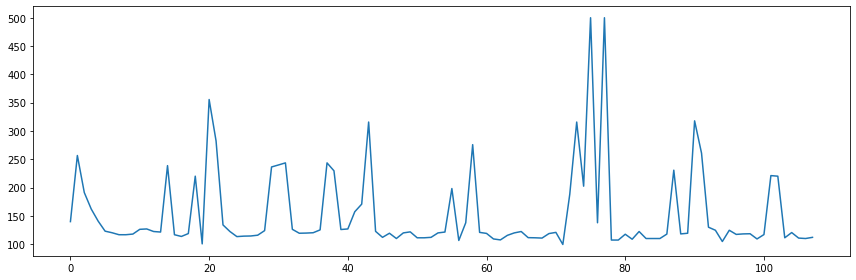

In [69]:
plt.figure(figsize=(12,4))
plt.plot(np.array(pitches))
plt.tight_layout()
plt.show()

In [70]:
window_size/44100

0.027210884353741496

## Audio de voz conversacion

In [142]:
sample_rate, data = wavfile.read("assets/conversation.wav")
data = data.astype(np.float64)
min_freq = 80
max_freq = 500
window_size = int(sample_rate * 0.025)# int(sample_rate // min_freq * 1.2)

min_bound = sample_rate // max_freq
max_bound = sample_rate // min_freq
bounds = [min_bound, max_bound]

209000 175940 418380
0 0 0
hola


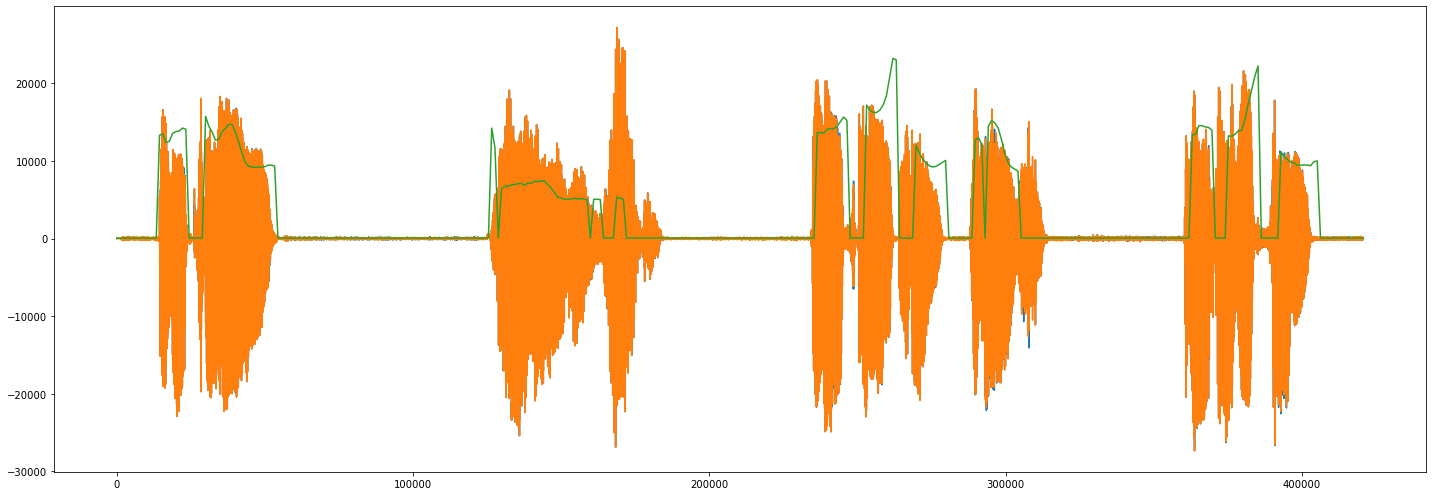

Wall time: 26.2 s


In [143]:
%%time
pitches = []
clear_cache_dicts()
e = 0
for i in range((data.shape[0]-bounds[1]) // (window_size+3)):
    p, e = detect_pitch_cmndf_cache(
            data[:,0],
            window_size,
            i*window_size,
            sample_rate,
            bounds,
            0.25,
            e
        ) 
    pitches.append(p)
plt.figure(figsize=(20,7))
plt.plot(data)
plt.plot(np.linspace(0, len(data), len(pitches)),60*np.array(pitches))
plt.tight_layout()
plt.show()

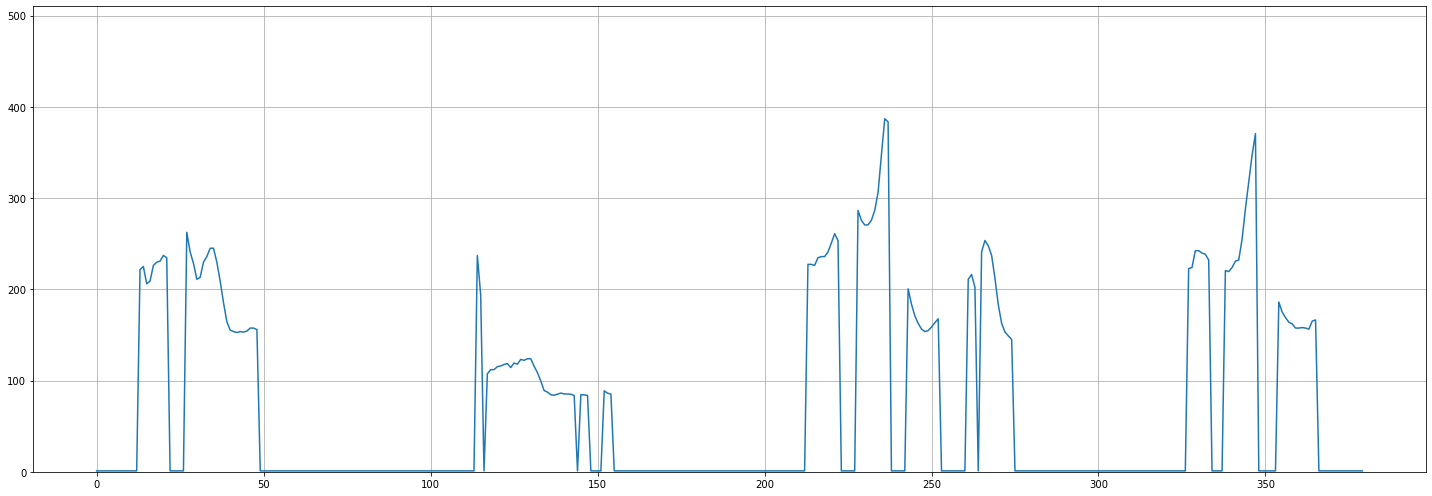

In [144]:
plt.figure(figsize=(20,7))
plt.plot(np.array(pitches))
plt.tight_layout()
plt.grid()
plt.gca().set_ylim([0, 510])
plt.savefig("fig.png")
plt.show()


## Audio de voz conversacion

In [149]:
sample_rate, data = wavfile.read("assets/convesp.wav")
data = data.astype(np.float64)
min_freq = 80
max_freq = 800
window_size = int(sample_rate * 0.025)# int(sample_rate // min_freq * 1.2)

min_bound = sample_rate // max_freq
max_bound = sample_rate // min_freq
bounds = [min_bound, max_bound]

284900 239834 570318
0 0 0
hola


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16672/2132636799.py:10: RuntimeWarning: invalid value encountered in double_scalars
  _CMNDF_cache_dict[(lag, t)] = DF_cache(f, W, t, lag) / np.sum([DF_cache(f, W, t, j+1) for j in range(lag)])*lag


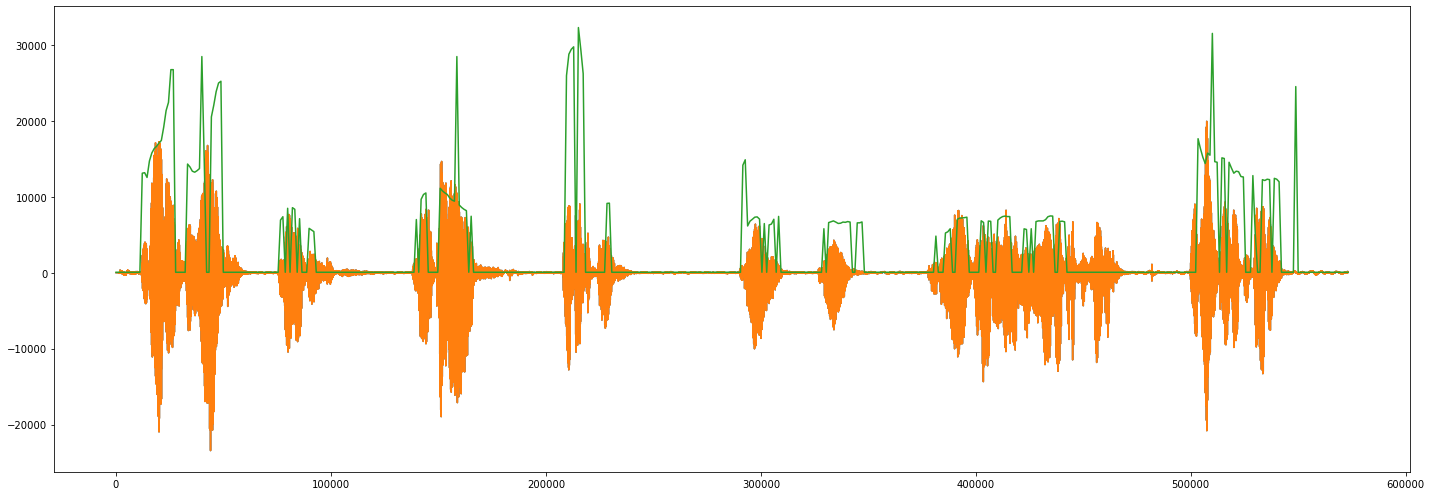

Wall time: 36.1 s


In [150]:
%%time
pitches = []
clear_cache_dicts()
e = 0
for i in range((data.shape[0]-bounds[1]) // (window_size+3)):
    p, e = detect_pitch_cmndf_cache(
            data[:,0],
            window_size,
            i*window_size,
            sample_rate,
            bounds,
            0.25,
            e
        ) 
    pitches.append(p)
plt.figure(figsize=(20,7))
plt.plot(data)
plt.plot(np.linspace(0, len(data), len(pitches)),60*np.array(pitches))
plt.tight_layout()
plt.show()

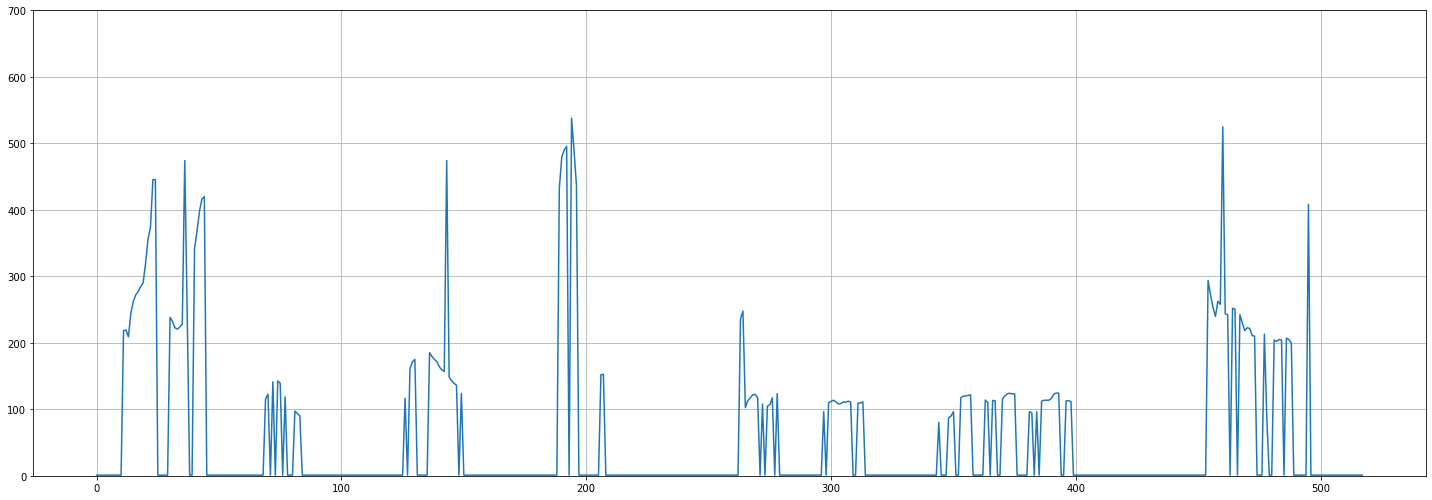

In [152]:
plt.figure(figsize=(20,7))
plt.plot(np.array(pitches))
plt.tight_layout()
plt.grid()
plt.gca().set_ylim([0, 700])
plt.savefig("fig.png")
plt.show()


In [ ]:
import requests
from time import sleep
url = 'https://www2.spsc.tugraz.at/databases/PTDB-TUG/SPEECH DATA/FEMALE/MIC/F01/mic_F01_si{}.wav'
filename = 'mic_F01_si{}.wav'
print(requests.get(url.format(453)))
input()
for i in range(453,500):
    r = requests.get(url.format(i))
    with open(filename.format(i), "wb+") as f:
        f.write(r.content)
    sleep(1)

<Response [200]>
